<a href="https://colab.research.google.com/github/charlesm93/stanTutorial/blob/main/CourseScript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This notebook contains the code to do the exercises.

The first step is to install the requisite packages to run Stan and do Bayesian analysis.

In [1]:
rm(list = ls())
gc()

set.seed(1954)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,632285,33.8,1413014,75.5,1278137,68.3
Vcells,1171610,9.0,8388608,64.0,1815549,13.9


## Install requisite packages

In [2]:
install_packages <- TRUE
if (install_packages) {
  install.packages("rjson")
  install.packages("posterior")
  install.packages("bayesplot")
  install.packages("outbreaks")
  install.packages("loo")
  install.packages("gridExtra")
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘abind’, ‘checkmate’, ‘tensorA’, ‘distributional’, ‘matrixStats’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘Rcpp’, ‘ggridges’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
if (install_packages) {
  install.packages("cmdstanr", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
  library(cmdstanr)
  install_cmdstan()
}

## Load packages

In [4]:
library(rjson)
library(bayesplot)
library(posterior)
library(ggplot2)
library(cmdstanr)
library(parallel)
library(loo)
library(outbreaks)
library(gridExtra)

This is bayesplot version 1.10.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

This is posterior version 1.4.1


Attaching package: ‘posterior’


The following object is masked from ‘package:bayesplot’:

    rhat


The following objects are masked from ‘package:stats’:

    mad, sd, var


The following objects are masked from ‘package:base’:

    %in%, match


This is loo version 2.6.0

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 



In [5]:
mc.cores = detectCores()

Upload the `tools_is.r` from your computer and then source it.

In [19]:
source("tools_is.r")

## Bayesian Linear Regression



In [6]:
data <- list(N = 10,
             x = 1:10,
             y = c(12.03037, 13.86786, 16.00795, 18.29419, 20.26679, 22.38664,
                   23.95751, 25.71993, 28.09961, 30.46859))

# define starting distribution
init <- function() {
  list(sigma = rgamma(1, 1),
       beta = rnorm(1, mean = 1, sd = 1))
}

In [7]:
# transpile (translate Stan to C++ and then compile)
mod <- cmdstan_model("model/linear.stan")

In [ ]:
# run sampler
n_chains <- 4
fit <- mod$sample(data = data, chains = n_chains,
                  init = init,
                  save_warmup = TRUE,
                  parallel_chains = detectCores())


In [15]:
# Examine Stan's default summaries
fit$summary()

variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-27.138396,-26.811000,1.0618839,0.8005299,-29.263130,-26.113950,1.0027766,1702.620,1914.989
beta,3.326371,3.331225,0.2344582,0.2198622,2.923175,3.693593,1.0015704,1985.931,1548.932
sigma,4.447103,4.323165,0.8890540,0.8238141,3.203581,6.104766,1.0030169,2121.046,2115.891
y_pred[1],3.377228,3.368165,4.6100374,4.3556193,-4.008635,10.992430,1.0003470,3870.787,3805.560
y_pred[2],6.631148,6.704470,4.6577913,4.3151295,-1.086448,14.348205,1.0001369,3646.452,3426.715
y_pred[3],10.020917,10.003850,4.5092645,4.2504808,2.397872,17.491775,1.0002085,3963.914,3808.178
y_pred[4],13.251412,13.325050,4.5689153,4.3213342,5.547560,20.507415,0.9994649,3863.694,3836.196
y_pred[5],16.724166,16.828950,4.6724785,4.4779709,8.871310,24.214635,1.0000942,3726.579,3775.346
y_pred[6],19.921790,19.923000,4.7429667,4.4159982,12.272755,27.743090,1.0000946,3751.279,3825.953


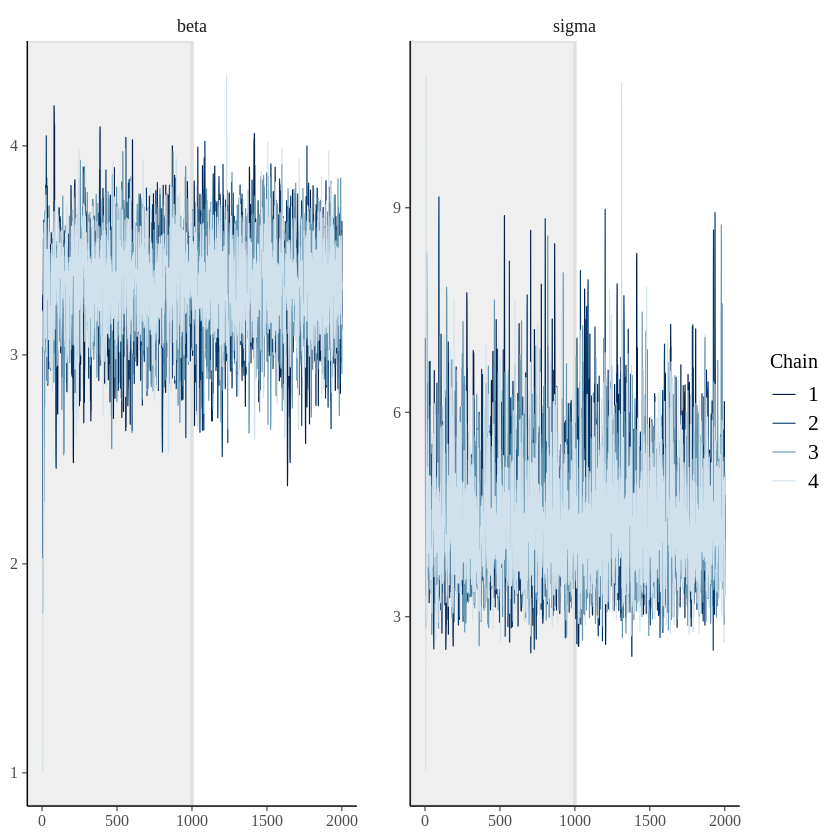

In [16]:
# Construct diagnostic plots
pars <- c("beta", "sigma")
bayesplot::mcmc_trace(fit$draws(inc_warmup = TRUE),
                      n_warmup = 1000, pars = pars)


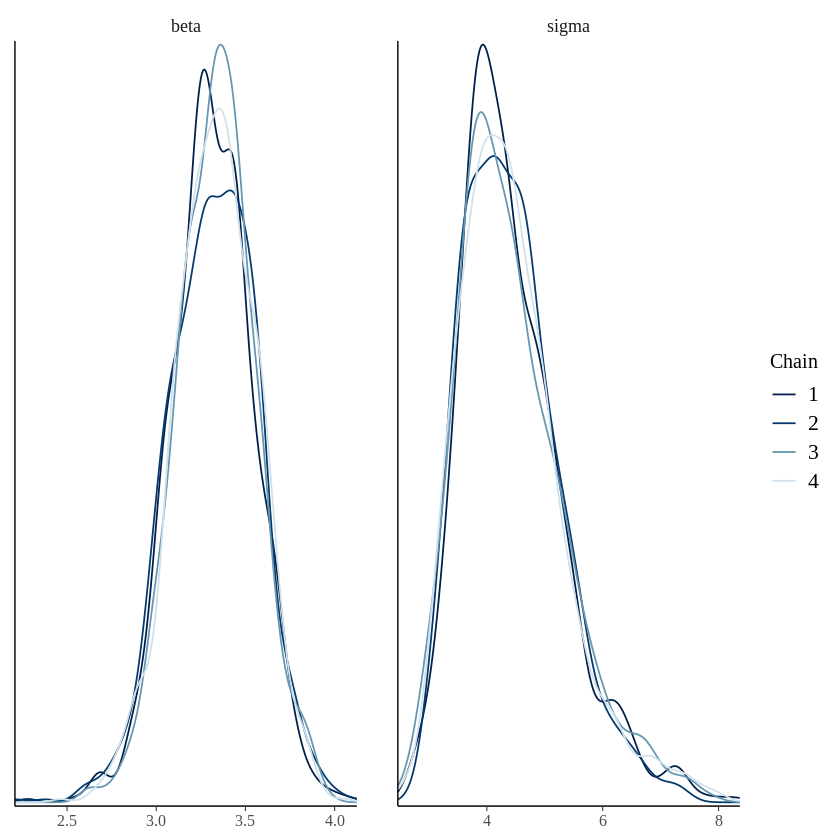

In [21]:
bayesplot::mcmc_dens_overlay(fit$draws(), pars = pars)

In [22]:
# Extract posterior predictive checks
yrep <- as.matrix(
  as_draws_df(fit$draws(variables = c("y_pred"))))
head(yrep)

y_pred[1],y_pred[2],y_pred[3],y_pred[4],y_pred[5],y_pred[6],y_pred[7],y_pred[8],y_pred[9],y_pred[10],.chain,.iteration,.draw
2.508180,6.58403,10.57110,9.46734,20.4269,26.1996,22.4488,20.0651,33.5489,34.1769,1,1,1
7.636070,10.16180,9.39898,14.26680,18.4368,18.5559,18.6609,27.6904,31.2208,37.4481,1,2,2
10.032100,2.35226,15.15430,15.65320,25.9737,20.4695,20.2809,26.3004,25.8428,40.2236,1,3,3
9.500110,2.11312,6.47932,13.44740,17.8165,15.7535,28.0225,31.6711,33.8193,37.1802,1,4,4
0.619144,6.23569,16.01270,11.44530,11.0006,18.5425,22.5011,31.8630,29.5887,35.5750,1,5,5
-3.559570,5.99911,6.44170,1.60113,23.7641,22.2031,22.2499,17.8432,30.5847,41.5398,1,6,6


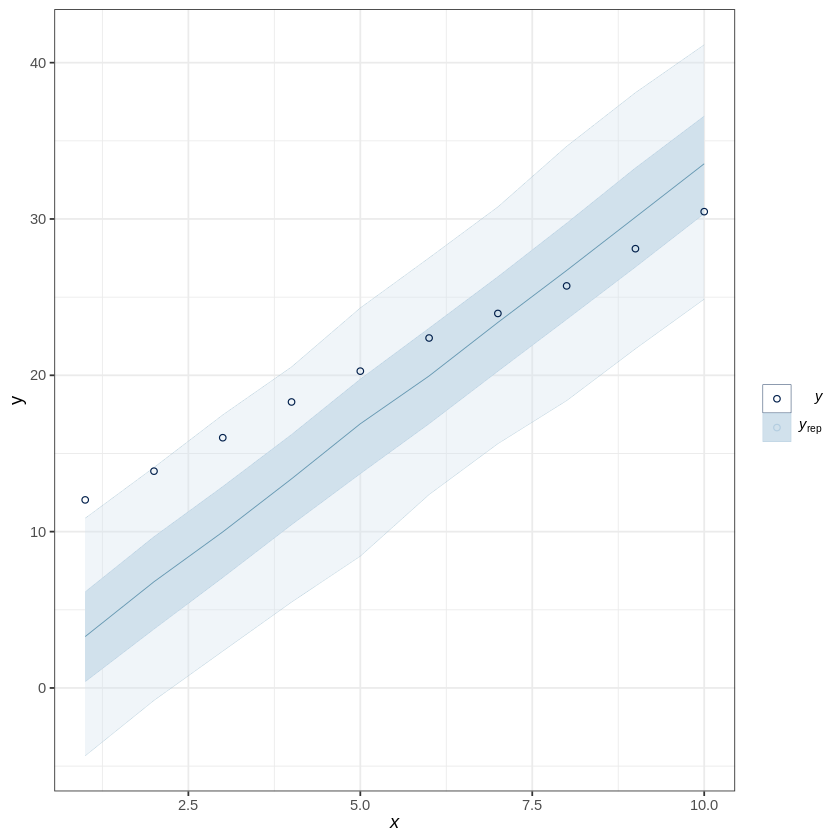

In [23]:
# We don't need the chain, iteration and draw ID, so let's remove them.
yrep <- yrep[, -(11:13)]

# Plot the posterior predictions and compare it to the real data.
bayesplot::ppc_ribbon(y = data$y, yrep = yrep, x = data$x,
                      y_draw = "point") +
  theme_bw() +
  ylab("y")


## SIR model

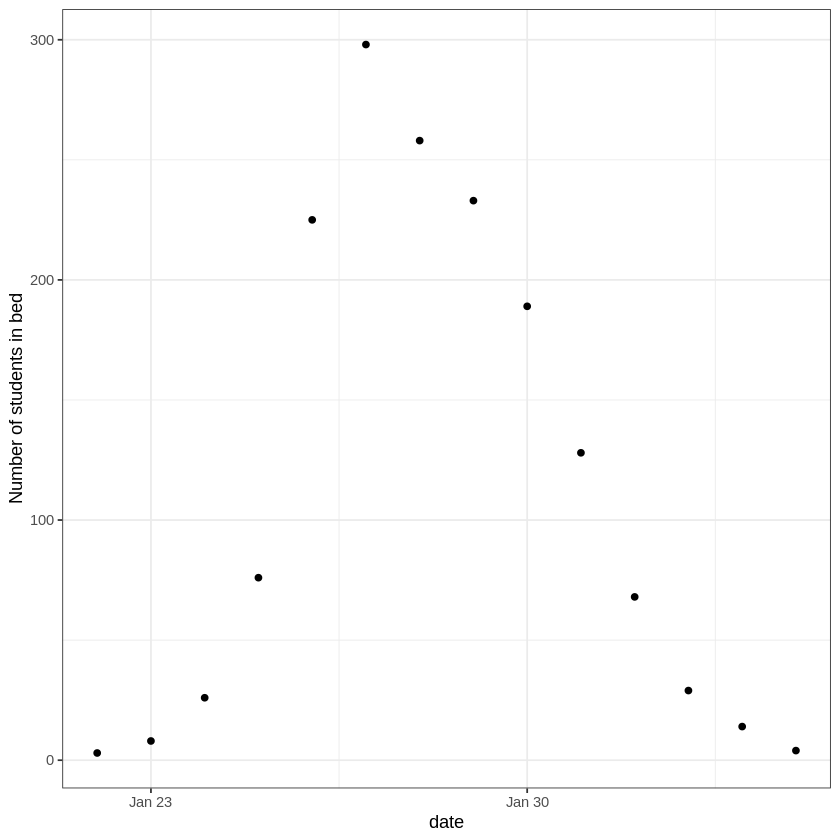

In [32]:
theme_set(theme_bw())
ggplot(data = influenza_england_1978_school) +
  geom_point(mapping = aes(x = date, y = in_bed)) +
  labs(y = "Number of students in bed")


In [33]:
# create a data list to be passed to Stan
cases <- influenza_england_1978_school$in_bed
N <- 763;
n_days <- length(cases)
t <- seq(0, n_days, by = 1)
t0 = 0
t <- t[-1]

#initial conditions
i0 <- 1
s0 <- N - i0
r0 <- 0
y0 = c(S = s0, I = i0, R = r0)

data_sir <- list(n_days = n_days, y0 = y0, t0 = t0, ts = t,
                 N = N, cases = cases)


In [ ]:
# define starting distribution
init <- function() {
  list(beta = abs(rnorm(1, mean = 2, sd = 1)),
       gamma = abs(rnorm(1, mean = 0.4, sd = 0.5)),
       phi_inv = rexp(1, rate = 5))
}

# transpile (translate Stan to C++ and then compile)
mod <- cmdstan_model("model/sir.stan")

n_chains <- 4
fit <- mod$sample(data = data_sir,
                  chains = n_chains,
                  parallel_chains = detectCores(),
                  init = init,
                  save_warmup = TRUE)

variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
gamma,0.5411385,0.5397915,0.04415096,0.04105245,0.4725459,0.6163206,1.000822,2558.203,2351.561
beta,1.7337744,1.7324550,0.05266971,0.05112005,1.6487835,1.8237125,1.001222,2468.276,2584.206
phi,9.4677676,8.3285850,5.32607621,4.08710566,3.6100915,19.1905400,1.001511,2210.330,2396.417
R0,3.2239479,3.2043600,0.26699041,0.24407303,2.8180680,3.6997815,1.000409,2459.997,1777.803


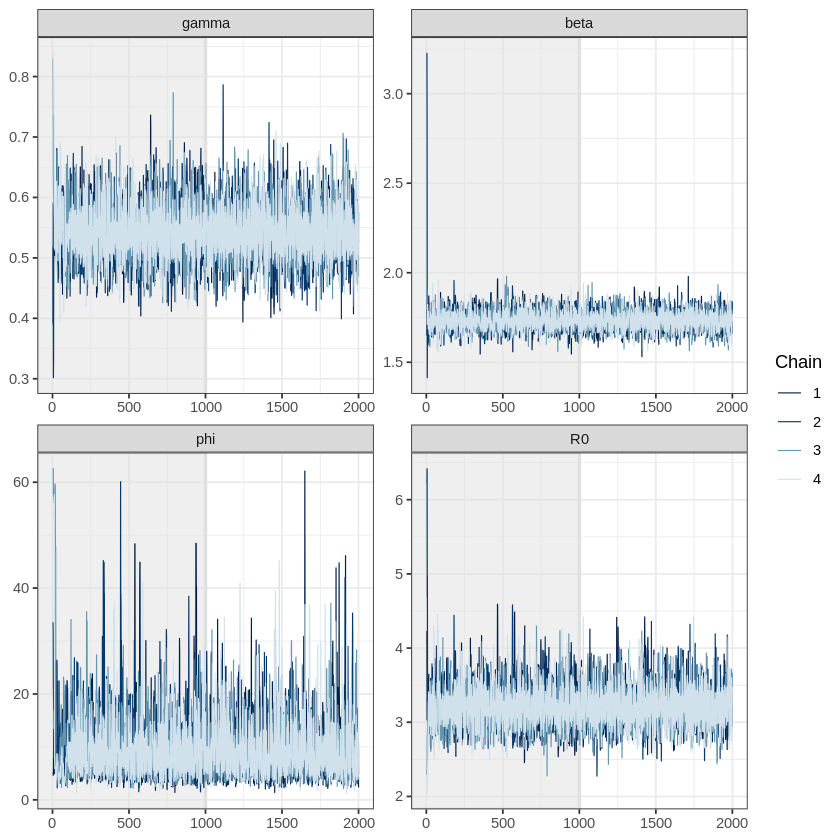

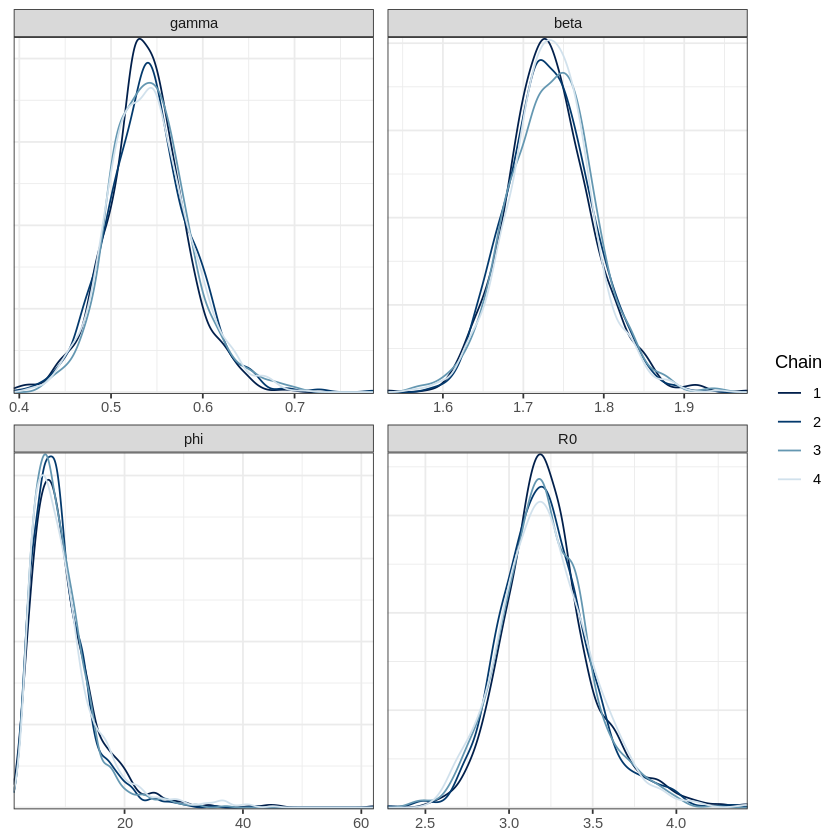

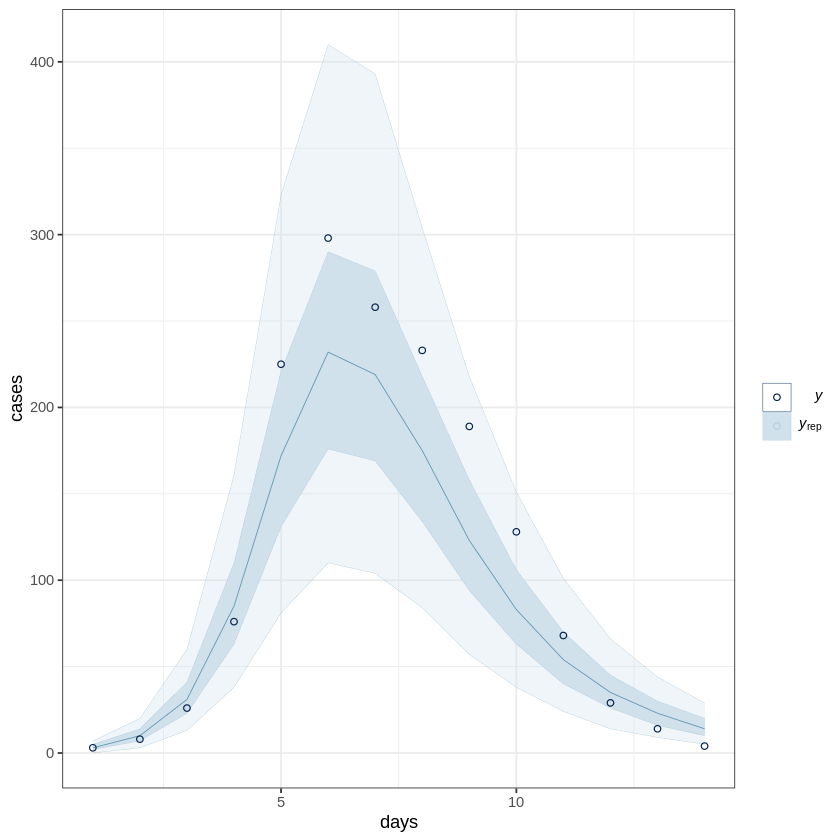

In [38]:
pars <- c("gamma", "beta", "phi", "R0")
fit$summary(variables = pars)

bayesplot::mcmc_trace(fit$draws(inc_warmup = TRUE),
                      n_warmup = 1000, pars = pars)
bayesplot::mcmc_dens_overlay(fit$draws(), pars = pars)

# Extract posterior predictive checks
pred_cases <- as.matrix(
  as_draws_df(fit$draws(variables = c("pred_cases"))))[, -(15:17)]

bayesplot::ppc_ribbon(y = data_sir$cases, yrep = pred_cases,
                      x = data_sir$ts, y_draw = "point") +
  theme_bw() +
  ylab("cases") + xlab("days")

In [ ]:
## Run same model with a Poisson likelihood

mod <- cmdstan_model("model/sir_poisson.stan")

fit_poisson <- mod$sample(data = data_sir,
                          chains = n_chains,
                          parallel_chains = detectCores(),
                          init = init,
                          save_warmup = TRUE)


variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
gamma,0.4767401,0.476449,0.01086194,0.01097198,0.4589358,0.4949937,1.001658,2974.826,2600.127
beta,1.6899619,1.690110,0.01527682,0.01496685,1.6642130,1.7148130,0.999724,3312.999,2711.437
phi,52.9611705,7.223605,609.90796652,6.87903420,1.6872660,110.3744000,1.004043,2402.534,1508.744
R0,3.5464545,3.546315,0.07775099,0.07799217,3.4181240,3.6717125,1.000985,3390.756,2951.582


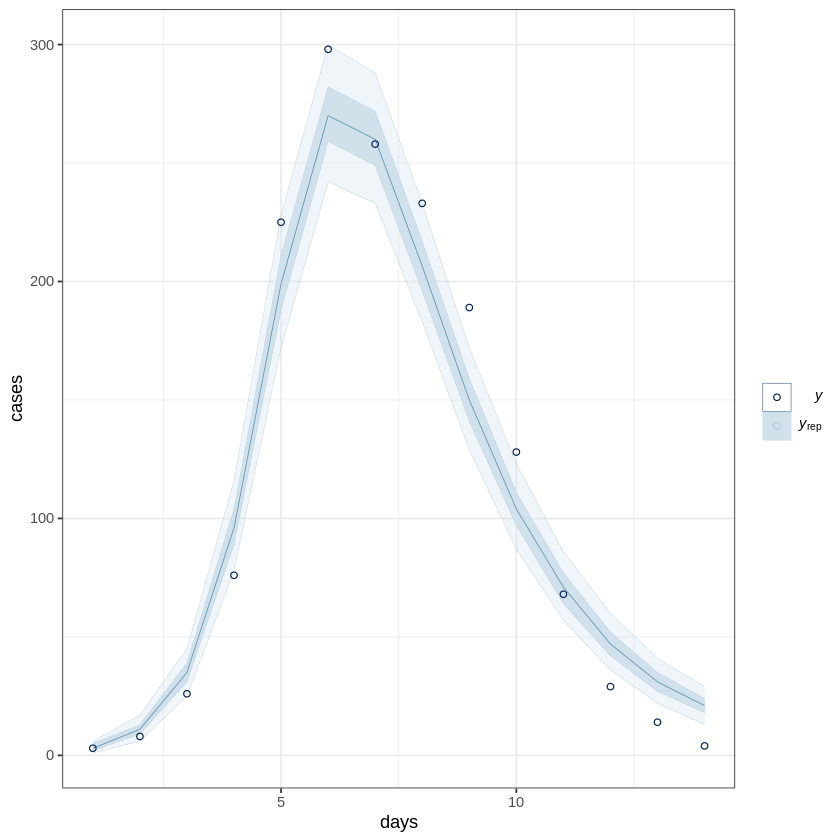

In [40]:
fit_poisson$summary(variables = pars)

pred_cases_poisson <- as.matrix(
  as_draws_df(fit_poisson$draws(variables = c("pred_cases"))))[, -(15:17)]

bayesplot::ppc_ribbon(y = data_sir$cases, yrep = pred_cases_poisson,
                      x = data_sir$ts, y_draw = "point") +
  theme_bw() +
  ylab("cases") + xlab("days")

In [41]:
# compute PSIS-loo estimate

log_lik_draws <- fit$draws("log_lik")
loo_estimate <- loo(log_lik_draws, r_eff = relative_eff(log_lik_draws))


log_lik_draws_poisson <- fit_poisson$draws("log_lik")
loo_estimate_poisson <-
  loo(log_lik_draws_poisson, r_eff = relative_eff(log_lik_draws_poisson))

print(loo_estimate_poisson)
print(loo_estimate)

Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”
Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”



Computed from 4000 by 14 log-likelihood matrix

         Estimate   SE
elpd_loo    -82.7 11.0
p_loo         9.2  2.1
looic       165.4 22.0
------
Monte Carlo SE of elpd_loo is 0.1.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     11    78.6%   665       
 (0.5, 0.7]   (ok)        3    21.4%   208       
   (0.7, 1]   (bad)       0     0.0%   <NA>      
   (1, Inf)   (very bad)  0     0.0%   <NA>      

All Pareto k estimates are ok (k < 0.7).
See help('pareto-k-diagnostic') for details.

Computed from 4000 by 14 log-likelihood matrix

         Estimate   SE
elpd_loo    -64.1  5.1
p_loo         2.7  1.1
looic       128.2 10.3
------
Monte Carlo SE of elpd_loo is 0.1.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     12    85.7%   1536      
 (0.5, 0.7]   (ok)        2    14.3%   252       
   (0.7, 1]   (bad)       0     0.0%   <NA>      
   (1, Inf)   (very bad)  0     0.0%   

In [ ]:
## run SIR model with custom tolerance for the ODE solver

mod <- cmdstan_model("model/sir_tol.stan")

tol <- 1e-4
data_sir$tol <- tol
fit_tol <- mod$sample(data = data_sir,
                      chains = n_chains,
                      parallel_chains = detectCores(),
                      init = init,
                      save_warmup = TRUE)


In [45]:
fit_tol$time()

chain_id,warmup,sampling,total
<int>,<dbl>,<dbl>,<dbl>
1,26.548,1.350,27.898
2,1.865,1.313,3.178
3,1.704,1.481,3.185
4,0.917,0.712,1.629


In [46]:
log_lik <- fit_tol$draws("log_lik")

fit_tol$summary(variables = pars)
loo_estimate <- loo(log_lik, r_eff = relative_eff(log_lik))
print(loo_estimate)

variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
gamma,0.5417761,0.541004,0.04422384,0.04138085,0.4719091,0.6172962,1.000248,2761.871,1982.552
beta,1.7357198,1.733860,0.05393480,0.04972640,1.6518040,1.8257865,1.001939,2451.367,1777.642
phi,9.4348936,8.234830,5.22089904,4.05733505,3.6675975,19.1430000,1.000077,2174.473,2334.726
R0,3.2244607,3.203645,0.27675521,0.25013686,2.8143155,3.6974110,1.000311,2661.598,1759.677



Computed from 4000 by 14 log-likelihood matrix

         Estimate   SE
elpd_loo    -64.0  5.1
p_loo         2.6  1.0
looic       128.0 10.3
------
Monte Carlo SE of elpd_loo is 0.1.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.


In [51]:
log_ratios <- fit_tol$draws("log_ratios")

psis_fit <- psis(log_ratios, r_eff =  relative_eff(log_ratios))
psis_fit$diagnostics

# Correct Monte Carlo samplers, using importance weights.
# Only works if the log ratios don't go to 0!
is_summary(fit_tol, pars, psis_fit, log_ratios)


$pareto_k
[1] -0.01239866

$n_eff
log_ratios 
  2482.453

parms,mean,var,q5,q25,q50,q75,q95,khat
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
gamma,0.5417905,4.889732e-07,0.4718414,0.5136478,0.541004,0.5691828,0.6173308,-0.03656122
beta,1.7357582,7.277240e-07,1.6517088,1.7011279,1.733877,1.7682844,1.8258811,0.04513222
phi,9.4313836,6.797869e-03,3.6673513,5.8696472,8.230924,11.6743672,19.1365962,0.07268944
R0,3.2244487,1.914929e-05,2.8140334,3.0415283,3.203537,3.3825678,3.6974037,0.10406874


## 8 schools

In [52]:
n_schools <- 8
y <- c(28, 8, -3, 7, -1, 1, 18, 12)
sigma <- c(15, 10, 16, 11, 9, 11, 10, 18)

stan_data <- list(n_schools = n_schools,
                  y = y,
                  sigma = sigma)

In [55]:
mod <- cmdstan_model("model/8schools.stan")
# other models: 8schools_nc, 8schools_marginal

fit <- mod$sample(data = stan_data,
                  chains = 4, parallel_chains = detectCores(),
                  iter_warmup = 1000,
                  iter_sampling = 1000,
                  # adapt_delta = 0.8,
                  seed = 1234)

Running MCMC with 4 chains, at most 2 in parallel...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 1 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 1 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 1 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
C

See https://mc-stan.org/misc/warnings for details.




In [56]:
fit$summary()

variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-15.924647,-16.192200,5.554420,5.978585,-24.8222300,-6.346908,1.019375,174.9575,116.89869
mu,5.844511,5.861560,2.599231,2.698784,1.7460345,10.102900,1.004449,706.8614,786.20211
tau,4.796793,3.945525,3.468523,3.109168,0.8814465,11.633115,1.022109,170.8084,54.87639
theta[1],8.285251,7.507895,6.044834,4.853202,0.3404072,19.573940,1.006053,853.9936,1449.07075
theta[2],6.268803,6.164755,5.062666,4.482693,-1.2990600,14.418350,1.005741,1721.2704,1641.47035
theta[3],5.030884,5.328775,5.578172,4.636439,-4.8451985,13.310255,1.002132,1725.8975,1850.41863
theta[4],6.088126,5.990055,5.133998,4.510536,-1.7899965,14.646810,1.004459,1443.1973,1736.55481
theta[5],4.254768,4.652550,4.974220,4.343418,-4.3644560,11.796010,1.004143,1182.6307,1141.74608
theta[6],5.008420,5.190615,5.032149,4.452233,-3.6101010,12.710950,1.001615,1297.2177,1918.02207


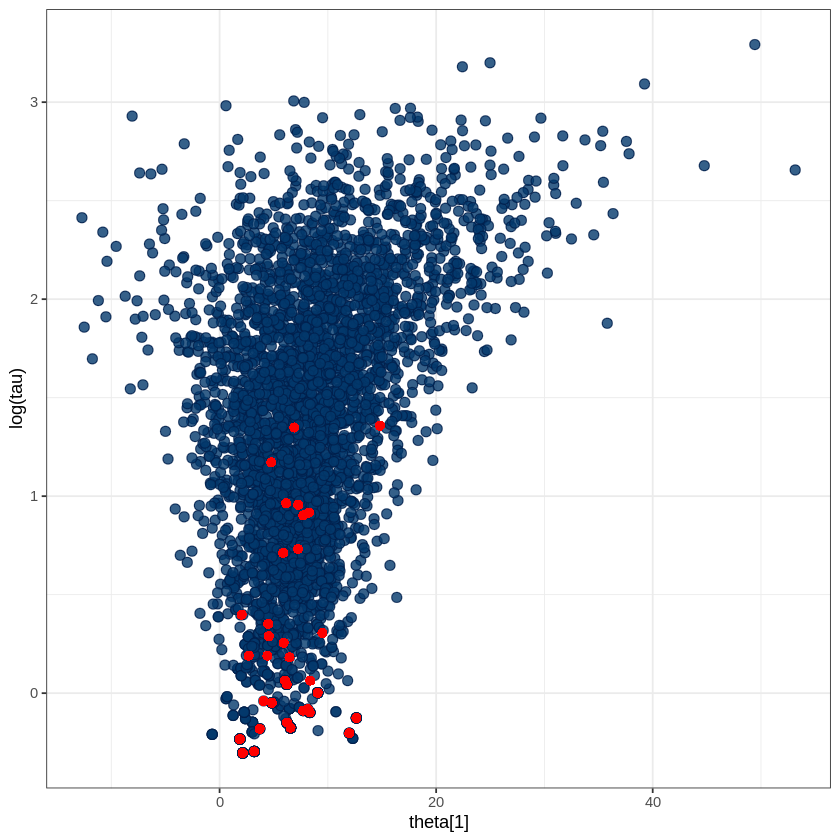

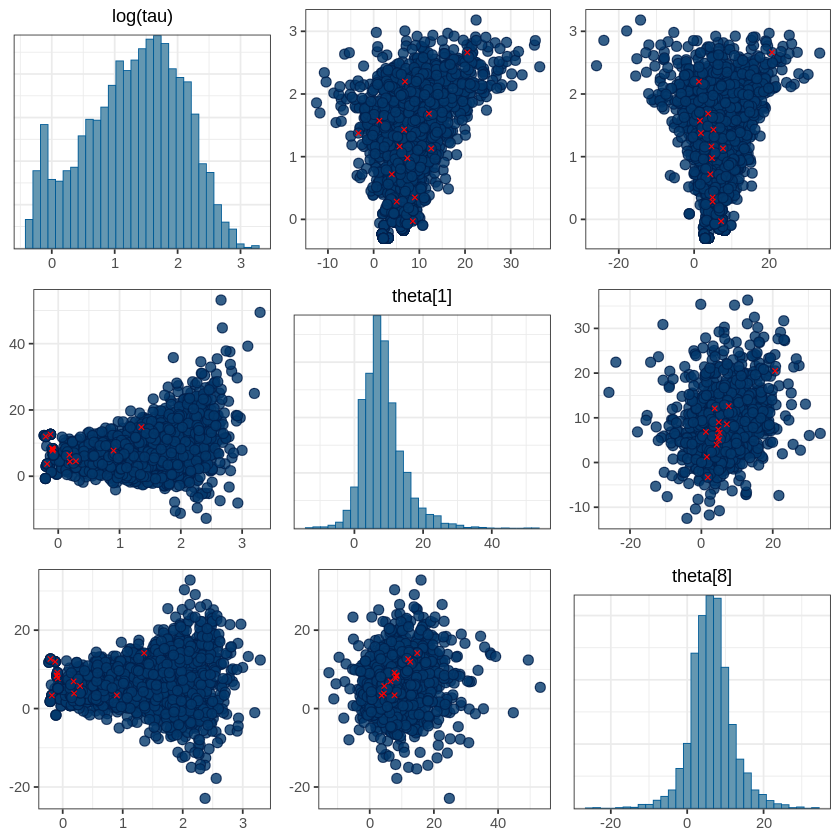

In [60]:
mcmc_draws <- fit$draws()

# plot log tau against theta to identify divergent transitions
np <- nuts_params(fit)
mcmc_scatter(mcmc_draws, pars = c("theta[1]", "tau"),
             transform = list(tau = "log"), np = np)

mcmc_pairs(mcmc_draws, pars = "tau", regex_pars = "theta\\[[1,8]\\]",
           transform = list(tau = "log"), np = np)


## Disease map of Finland

Upload `disease_100.json` and added it to the `data` folder (you may need to create this folder).

In [61]:
data <- fromJSON(file = "data/disease_100.json")

In [63]:
mod <- cmdstan_model("model/disease_map.stan")

fit <- mod$sample(data = data,
                  chains = 4, parallel_chains = detectCores(),
                  iter_warmup = 500,
                  iter_sampling = 500,
                  adapt_delta = 0.8,
                  seed = 1234)

Running MCMC with 4 chains, at most 2 in parallel...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: gp_exp_quad_cov: sigma is 0, but must be positive! (in '/tmp/RtmpEIIU9b/model-3be6ac5c527.stan', line 25, column 5 to column 44)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: gp_exp_quad_cov: sigma is 0, but must be positive! (in '/tmp/RtmpEIIU9b/model-3be6ac5c527.stan', line 25, column 5 to column 44)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your

Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: gp_exp_quad_cov: sigma is 0, but must be positive! (in '/tmp/RtmpEIIU9b/model-3be6ac5c527.stan', line 25, column 5 to column 44)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: cholesky_decompose: Matrix m is not positive definite (in '/tmp/RtmpEIIU9b/model-3be6ac5c527.stan', line 27, column 5 to column 41)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then y

Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 finished in 69.9 seconds.
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: gp_exp_quad_cov: sigma is 0, but must be positive! (in '/tmp/RtmpEIIU9b/model-3be6ac5c527.stan', line 25, column 5 to column 44)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 



Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 90.5 seconds.
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: gp_exp_quad_cov: sigma is 0, but must be positive! (in '/tmp/RtmpEIIU9b/model-3be6ac5c527.stan', line 25, column 5 to column 44)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: gp_exp_quad_cov: sigma is 0, but must be positive! (in '/tmp/RtmpEIIU9b/model-3be6ac5c527.stan', line 25, column 5 to column 44)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your

Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 3 finished in 82.8 seconds.
Chain 4 Iteration: 800 / 1000 [ 80%

See https://mc-stan.org/misc/warnings for details.




In [64]:
pars <- c("alpha", "rho", "theta[1]")
fit$summary(variables = pars)

variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
alpha,0.7274650,0.6934200,0.21171273,0.18798997,0.4520429,1.10562850,1.003168,631.1588,645.7613
rho,20.8789666,17.9398000,12.04491919,6.39297120,10.4224700,40.47238000,1.004511,227.5315,267.8509
theta[1],-0.0917402,-0.0913263,0.02453251,0.02253085,-0.1323685,-0.05358334,1.001341,1089.0466,491.7099


## Pharmacokinetic model

In [6]:
# Download Torsten
system("git clone https://github.com/metrumresearchgroup/Torsten.git")

To build the Stan binaries with `Torsten`, we can open a shell window (bottom left icon on Colab) and type the following commands:
```
cd Torsten/cmdstan
make examples/TwoCptModelPopulation/TwoCptModelPopulation
```

In [7]:
# Make cmdstanr use Torsten
cmdstan_path <- "Torsten/cmdstan/"
set_cmdstan_path(cmdstan_path)
bayesplot::color_scheme_set("mix-blue-green")


CmdStan path set to: /content/Torsten/cmdstan



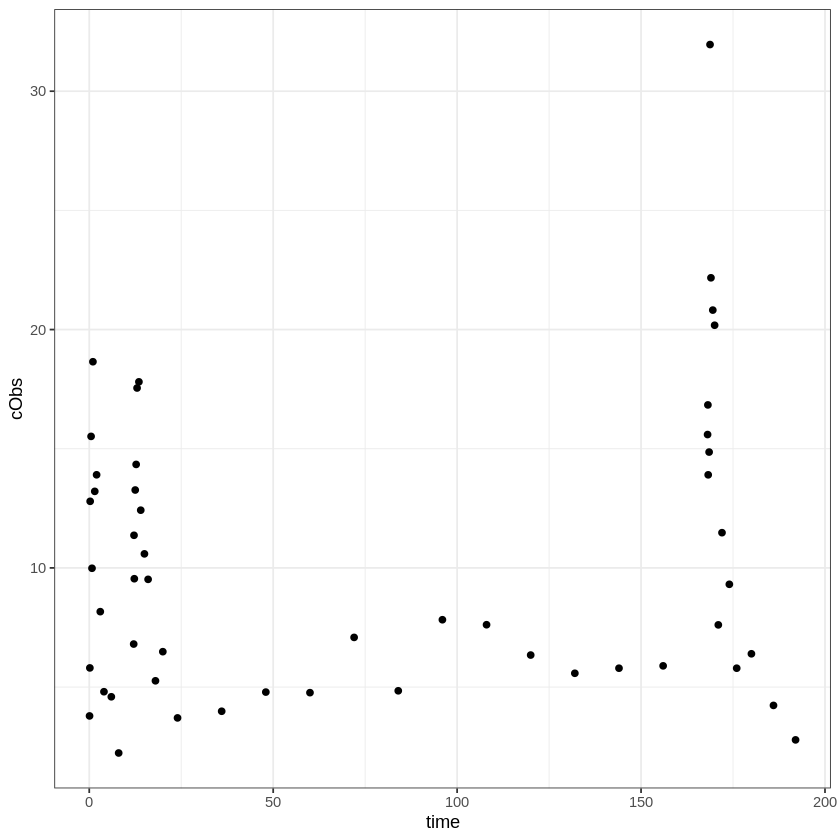

In [23]:
data <- fromJSON(file = "data/twoCpt.data.json")

# Plot drug concentration profile
p <- ggplot(data = data.frame(time = data$time[-1],
                              cObs = data$cObs),
            aes(x = time, y = cObs)) +
  geom_point() +
  theme_bw()
p

In [24]:
# Draw initial conditions from the prior
init <- function() {
  list(CL = exp(rnorm(1, log(10), 0.25)),
       Q = exp(rnorm(1, log(15), 0.5)),
       VC = exp(rnorm(1, log(35), 0.25)),
       VP = exp(rnorm(1, log(105), 0.5)),
       ka = exp(rnorm(1, log(2), 1)),
       sigma = abs(rnorm(1, 0, 1)))
}

In [29]:
model_name <- "twoCpt_ode"
mod <- cmdstan_model(paste0("model/", model_name, ".stan"))


In file included from stan/lib/stan_math/lib/boost_1.75.0/boost/concept/assert.hpp:35,
                 from stan/lib/stan_math/lib/boost_1.75.0/boost/concept_check.hpp:20,
                 from stan/lib/stan_math/lib/boost_1.75.0/boost/range/concepts.hpp:19,
                 from stan/lib/stan_math/lib/boost_1.75.0/boost/range/size_type.hpp:20,
                 from stan/lib/stan_math/lib/boost_1.75.0/boost/range/size.hpp:21,
                 from stan/lib/stan_math/lib/boost_1.75.0/boost/range/functions.hpp:20,
                 from stan/lib/stan_math/lib/boost_1.75.0/boost/range/iterator_range_core.hpp:38,
                 from stan/lib/stan_math/lib/boost_1.75.0/boost/lexical_cast.hpp:30,
                 from stan/lib/stan_math/stan/math/prim/core/init_threadpool_tbb.hpp:6,
                 from stan/lib/stan_math/stan/math/prim/core.hpp:4,
                 from stan/lib/stan_math/stan/math/rev/core/Eigen_NumTraits.hpp:5,
                 from stan/lib/stan_math/stan/math/rev/core

In [30]:
n_chains <- 4
fit <- mod$sample(data = data, chains = n_chains, init = init,
                  parallel_chains = detectCores(),
                  iter_warmup = 500, iter_sampling = 500)

Running MCMC with 4 chains, at most 2 in parallel...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: Max number of iterations exceeded (1000). (in '/tmp/RtmpBMyYdw/model-184279792a.stan', line 68, column 2 to line 70, column 57)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: Max number of iterations exceeded (1000). (in '/tmp/RtmpBMyYdw/model-184279792a.stan', line 68, column 2 to line 70, column 57)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: Max number of iterations exceeded (1000). (in '/tmp/RtmpBMyYdw/model-184279792a.stan', line 68, column 2 to line 70, column 57)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your m

Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: Max number of iterations exceeded (1000). (in '/tmp/RtmpBMyYdw/model-184279792a.stan', line 68, column 2 to line 70, column 57)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: Max number of iterations exceeded (1000). (in '/tmp/RtmpBMyYdw/model-184279792a.stan', line 68, column 2 to line 70, column 57)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 finished in 63.5 seconds.
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: PMX Variadic ODE System: initial state[2] is -nan, but must be finite! (in '/tmp/RtmpBMyYdw/model-184279792a.stan', line 68, column 2 to line 70, column 57)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: twoCpt_ode_model_namespace::log_prob: mass[2, 31] is -0.000132514, but must be greater than or equal to 0.000000 (in '/tmp/RtmpBMyYdw/model-184279792a.stan', line 62, column 2 to column 39)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covarianc

Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 71.6 seconds.
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: Max number of iterations exceeded (1000). (in '/tmp/RtmpBMyYdw/model-184279792a.stan', line 68, column 2 to line 70, column 57)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: Max number of iterations exceeded (1000). (in '/tmp/RtmpBMyYdw/model-184279792a.stan', line 68, column 2 to line 70, column 57)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your m

Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: Max number of iterations exceeded (1000). (in '/tmp/RtmpBMyYdw/model-184279792a.stan', line 68, column 2 to line 70, column 57)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: Max number of iterations exceeded (1000). (in '/tmp/RtmpBMyYdw/model-184279792a.stan', line 68, column 2 to line 70, column 57)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your m

Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 3 finished in 59.4 seconds.
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 4 finished in 59.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 63.5 seconds.
Total execut

In [32]:
# Save fit (useful for expensive models!)
system("mkdir deliv")
fit$save_object(paste0("deliv/", model_name, ".fit.RDS"))

In [33]:
fit$time()

chain_id,warmup,sampling,total
<int>,<dbl>,<dbl>,<dbl>
1,33.622,37.994,71.616
2,32.354,31.138,63.492
3,30.657,28.700,59.357
4,33.407,26.139,59.546


variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CL,10.0309258,10.024750,0.36418706,0.35834442,9.4237980,10.6202450,1.0020675,1550.6839,1146.2044
Q,19.8521506,19.633400,3.79950699,3.67217781,13.9817800,26.5210750,0.9996965,1006.2145,1138.3151
VC,41.3445925,41.294050,9.48150686,9.86173629,26.1769350,57.1292850,1.0029765,925.7243,994.7898
VP,124.2476102,122.884000,17.59296156,16.13661840,98.4627500,155.0227000,1.0012904,1826.3391,1457.3077
ka,1.7367079,1.691175,0.50677609,0.48932472,1.0184020,2.6844735,1.0035604,932.4742,965.7682
sigma,0.2226211,0.221324,0.02285144,0.02209074,0.1872614,0.2616931,1.0056657,1577.6325,1175.9792


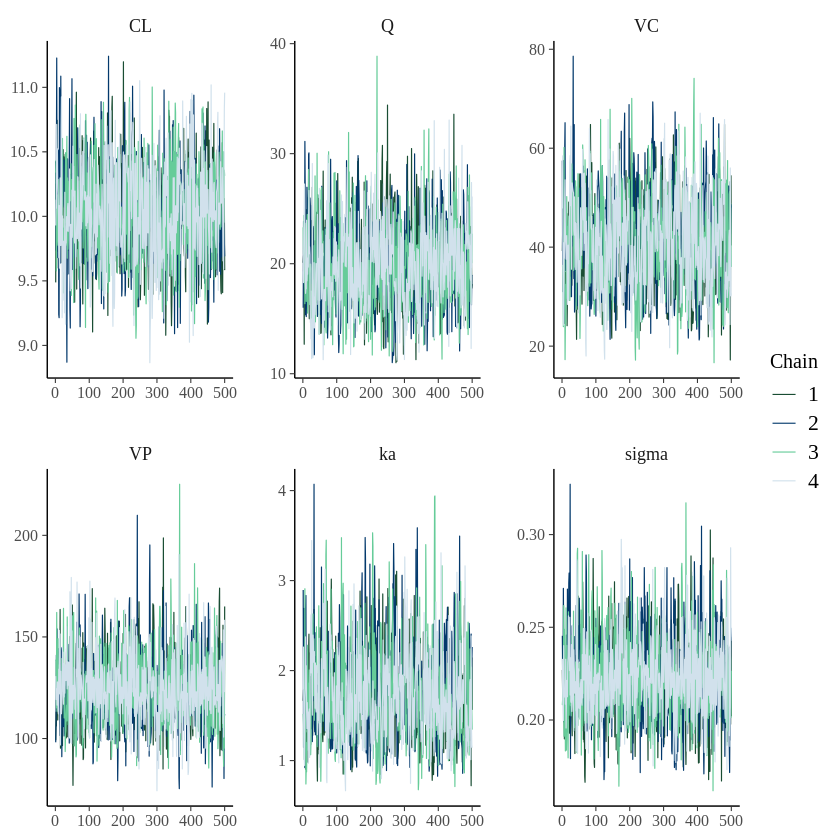

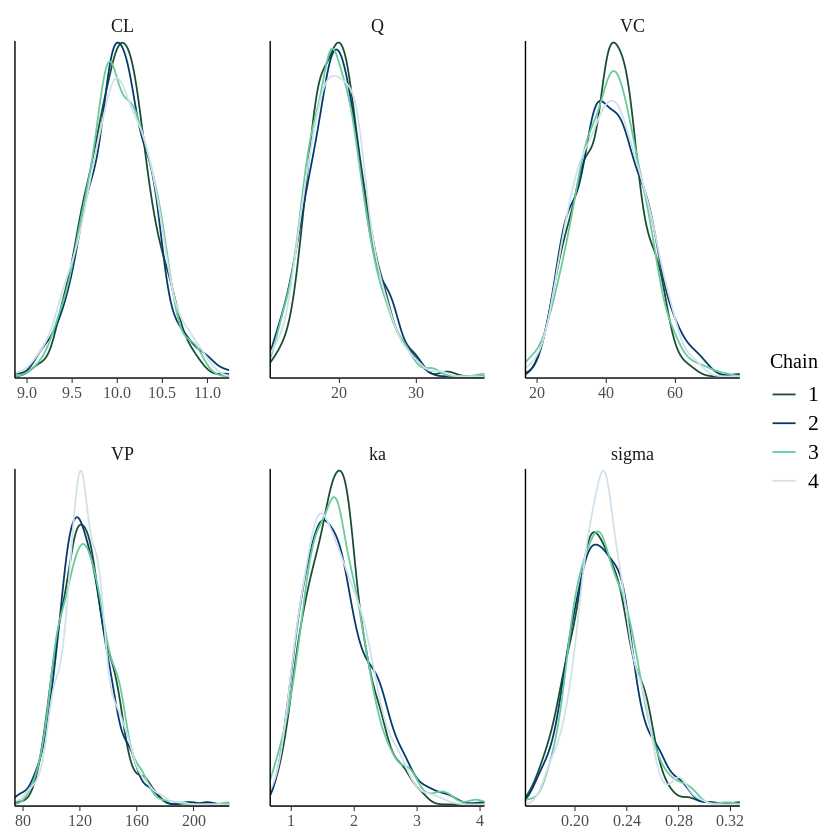

In [34]:
pars = c("CL", "Q", "VC", "VP", "ka", "sigma")
fit$summary(variables = pars)

bayesplot::mcmc_trace(fit$draws(), pars = pars)
bayesplot::mcmc_dens_overlay(fit$draws(), pars = pars)


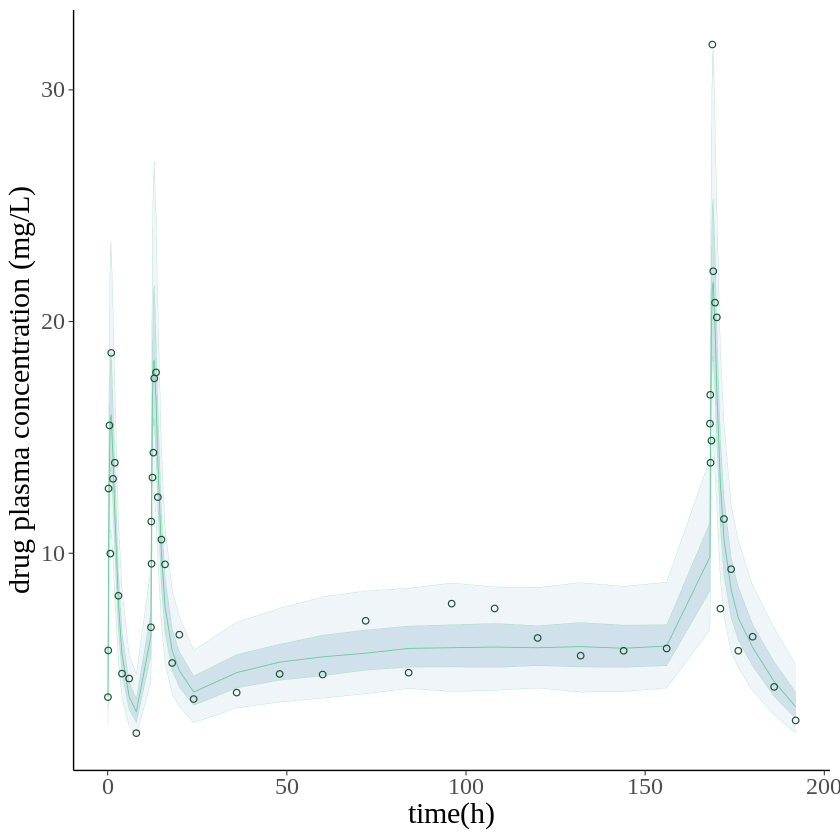

In [35]:
# posterior predictive checks
yrep <- as.matrix(
  as_draws_df(
    fit$draws(variables = c("concentrationObsPred"))
  ))[, -(52:54)]

yobs <- data$cObs
time <- data$time[-1]

p <- bayesplot::ppc_ribbon(y = yobs, yrep = yrep,
                           x = time, y_draw = "point") +
  xlab("time(h)") + ylab("drug plasma concentration (mg/L)") +
  theme(legend.position = "none") +
  theme(text = element_text(size = 18))
p

In [38]:
# PSIS check for ODE tolerance
log_ratios <- fit$draws("log_ratios")

psis_fit <- psis(log_ratios, r_eff =  relative_eff(log_ratios))
psis_fit$diagnostics

$pareto_k
[1] 0.2984183

$n_eff
log_ratios 
  1879.529

In [39]:
## Use built-in analytical solution

# two compartment model
mod <- cmdstan_model("model/twoCpt.stan")
fit <- mod$sample(data = data, chains = n_chains, init = init,
                  parallel_chains = detectCores(),
                  iter_warmup = 500, iter_sampling = 500)

Running MCMC with 4 parallel chains...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: PMXTwoCptModel: CL is 0, but must be positive finite! (in '/tmp/RtmpBMyYdw/model-1841607565.stan', line 37, column 2 to line 38, column 77)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: twoCpt_model_namespace::log_prob: mass[1, 1] is -nan, but must be greater than or equal to 0.000000 (in '/tmp/RtmpBMyYdw/model-1841607565.stan', line 37, column 2 to line 38, column 77)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the 

Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: twoCpt_model_namespace::log_prob: mass[1, 1] is -nan, but must be greater than or equal to 0.000000 (in '/tmp/RtmpBMyYdw/model-1841607565.stan', line 37, column 2 to line 38, column 77)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: PMXTwoCptModel: CL is inf, but must be positive finite! (in '/tmp/RtmpBMyYdw/model-1841607565.stan', line 37, column 2 to line 38, column 77)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: twoCpt_model_namespace::log_prob: mass[1, 1] is -nan, but must be greater than or equal to 0.000000 (in '/tmp/RtmpBMyYdw/model-1841607565.stan', line 37, column 2 to line 38, column 77)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then th

Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: twoCpt_model_namespace::log_prob: mass[1, 1] is -nan, but must be greater than or equal to 0.000000 (in '/tmp/RtmpBMyYdw/model-1841607565.stan', line 37, column 2 to line 38, column 77)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 



Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 500 / 1000 [ 50%]

chain_id,warmup,sampling,total
<int>,<dbl>,<dbl>,<dbl>
1,17.073,12.456,29.529
2,17.830,12.877,30.707
3,18.704,11.629,30.333
4,16.809,12.883,29.692


variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-2.4720300,-2.1465100,1.81712141,1.67157220,-5.9525875,-0.1841182,0.9990287,898.1119,1402.697
CL,10.0202700,10.0143500,0.36253388,0.36374850,9.4315205,10.6353400,1.0026664,1629.6802,1038.240
Q,19.6706646,19.4208000,3.98702071,3.91821528,13.6331950,26.3405050,1.0076068,985.9097,1434.236
VC,41.7780950,41.5662500,9.52240140,9.90065454,26.3462050,57.4506650,1.0051503,768.3693,1121.615
VP,123.1993155,122.3305000,18.38404998,17.83419540,94.8727900,155.5651000,1.0014055,1645.8784,1266.963
ka,1.7623776,1.7113500,0.51378895,0.50777567,1.0219305,2.6621370,1.0057118,728.9782,1191.144
sigma,0.2240772,0.2214015,0.02462602,0.02295584,0.1880605,0.2694349,1.0011048,1630.0611,1164.339
theta[1],10.0202700,10.0143500,0.36253388,0.36374850,9.4315205,10.6353400,1.0026664,1629.6802,1038.240
theta[2],19.6706646,19.4208000,3.98702071,3.91821528,13.6331950,26.3405050,1.0076068,985.9097,1434.236


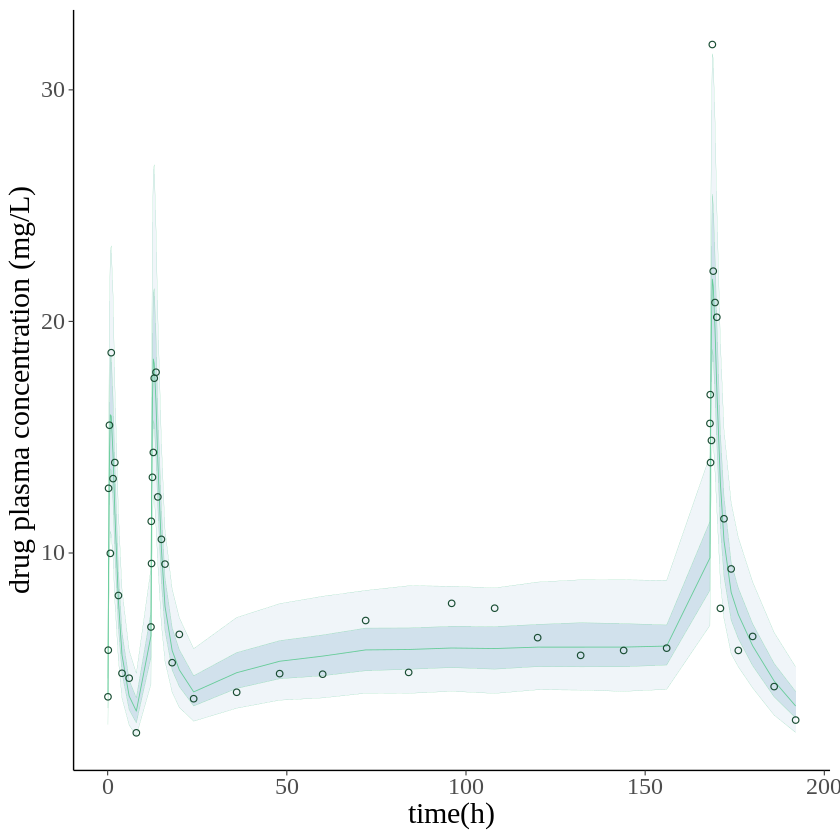

In [40]:
fit$time()
fit$summary()

yrep <- as.matrix(
  as_draws_df(
    fit$draws(variables = c("concentrationObsPred"))
  ))[, -(52:54)]

yobs <- data$cObs
time <- data$time[-1]

p <- bayesplot::ppc_ribbon(y = yobs, yrep = yrep,
                           x = time, y_draw = "point") +
  xlab("time(h)") + ylab("drug plasma concentration (mg/L)") +
  theme(legend.position = "none") +
  theme(text = element_text(size = 18))
p

In [41]:
# one compartment model
mod <- cmdstan_model("model/oneCpt.stan")
fit_one <- mod$sample(data = data, chains = n_chains, init = init,
                      parallel_chains = n_chains,
                      iter_warmup = 500, iter_sampling = 500)

Running MCMC with 4 parallel chains...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: PMXOneCptModel: CL is 0, but must be positive finite! (in '/tmp/RtmpBMyYdw/model-184400971b4.stan', line 34, column 2 to line 35, column 77)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: PMXOneCptModel: CL is 0, but must be positive finite! (in '/tmp/RtmpBMyYdw/model-184400971b4.stan', line 34, column 2 to line 35, column 77)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warnin

Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: PMXOneCptModel: CL is 0, but must be positive finite! (in '/tmp/RtmpBMyYdw/model-184400971b4.stan', line 34, column 2 to line 35, column 77)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: PMXOneCptModel: CL is 0, but must be positive finite! (in '/tmp/RtmpBMyYdw/model-184400971b4.stan', line 34, column 2 to line 35, column 77)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warnin

Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: PMXOneCptModel: CL is inf, but must be positive finite! (in '/tmp/RtmpBMyYdw/model-184400971b4.stan', line 34, column 2 to line 35, column 77)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: lognormal_lpdf: Location parameter[3] is -inf, but must be finite! (in '/tmp/RtmpBMyYdw/model-184400971b4.stan', line 48, column 2 to column 52)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this 

Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: lognormal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/tmp/RtmpBMyYdw/model-184400971b4.stan', line 48, column 2 to column 52)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 



Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: lognormal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/tmp/RtmpBMyYdw/model-184400971b4.stan', line 48, column 2 to column 52)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 



Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iterat

chain_id,warmup,sampling,total
<int>,<dbl>,<dbl>,<dbl>
1,4.399,3.053,7.452
2,4.253,3.096,7.349
3,4.089,3.372,7.461
4,3.566,3.374,6.940


variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-2.839396e+01,-2.808435e+01,1.49381685,1.314844e+00,-3.136339e+01,-2.666640e+01,1.004249,837.0777,1267.931
CL,9.582531e+00,9.581525e+00,0.47230334,4.583977e-01,8.801069e+00,1.034505e+01,1.002924,1440.3243,1555.711
VC,9.451366e+01,9.449900e+01,8.55938049,8.368684e+00,8.049249e+01,1.087869e+02,1.002823,1346.6493,1357.952
ka,5.124716e+00,4.869985e+00,1.34272952,1.211588e+00,3.358968e+00,7.649594e+00,1.002177,1406.1333,1646.239
sigma,3.385905e-01,3.353185e-01,0.03797245,3.600272e-02,2.823509e-01,4.079110e-01,1.004151,1378.5995,1388.913
theta[1],9.582531e+00,9.581525e+00,0.47230334,4.583977e-01,8.801069e+00,1.034505e+01,1.002924,1440.3243,1555.711
theta[2],9.451366e+01,9.449900e+01,8.55938049,8.368684e+00,8.049249e+01,1.087869e+02,1.002823,1346.6493,1357.952
theta[3],5.124716e+00,4.869985e+00,1.34272952,1.211588e+00,3.358968e+00,7.649594e+00,1.002177,1406.1333,1646.239
"mass[1,1]",1.250000e+03,1.250000e+03,0.00000000,0.000000e+00,1.250000e+03,1.250000e+03,NA,NA,NA


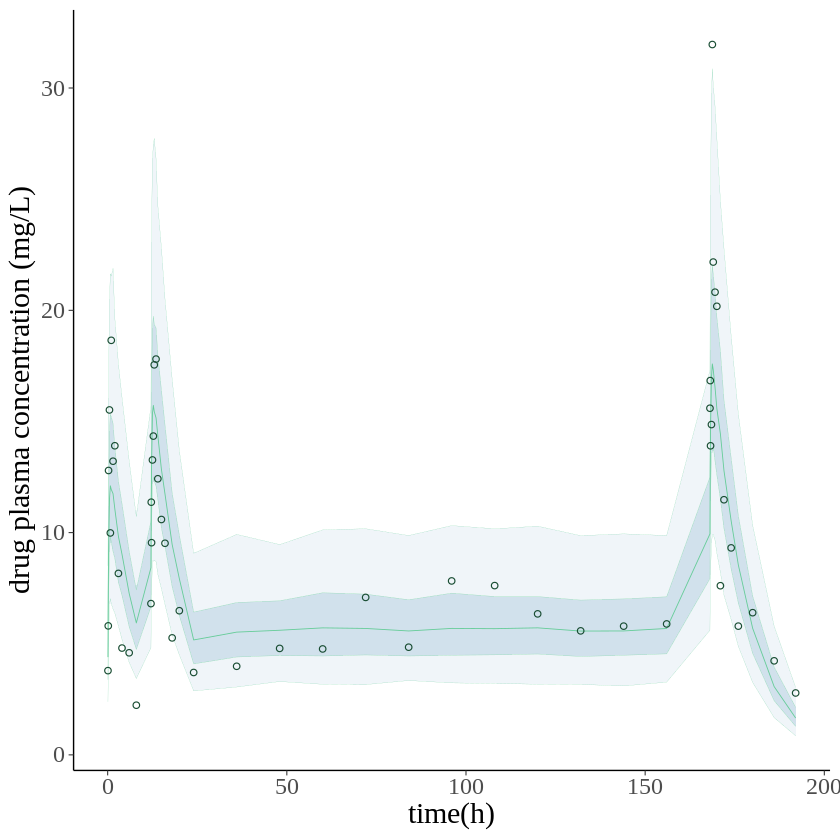

In [42]:
fit_one$time()
fit_one$summary()

yrep <- as.matrix(
  as_draws_df(
    fit_one$draws(variables = c("concentrationObsPred"))
  ))[, -(52:54)]

yobs <- data$cObs
time <- data$time[-1]

p <- bayesplot::ppc_ribbon(y = yobs, yrep = yrep,
                           x = time, y_draw = "point") +
  xlab("time(h)") + ylab("drug plasma concentration (mg/L)") +
  theme(legend.position = "none") +
  theme(text = element_text(size = 18))
p


In [43]:
# estimate ELPD_loo for both models
log_lik_draws <- fit$draws("log_lik")
loo_estimate <- loo(log_lik_draws, r_eff = relative_eff(log_lik_draws))


log_lik_draws_one <- fit_one$draws("log_lik")
loo_estimate_one <-
  loo(log_lik_draws_one, r_eff = relative_eff(log_lik_draws_one))

print(loo_estimate_one)
print(loo_estimate)

Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”



Computed from 2000 by 51 log-likelihood matrix

         Estimate   SE
elpd_loo   -128.2  5.8
p_loo         3.6  0.9
looic       256.4 11.7
------
Monte Carlo SE of elpd_loo is 0.1.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

Computed from 2000 by 51 log-likelihood matrix

         Estimate   SE
elpd_loo   -107.9  6.6
p_loo         4.8  1.0
looic       215.8 13.3
------
Monte Carlo SE of elpd_loo is 0.1.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     50    98.0%   642       
 (0.5, 0.7]   (ok)        1     2.0%   820       
   (0.7, 1]   (bad)       0     0.0%   <NA>      
   (1, Inf)   (very bad)  0     0.0%   <NA>      

All Pareto k estimates are ok (k < 0.7).
See help('pareto-k-diagnostic') for details.


## Population Pharmacokinetic Model

In [8]:
data <- fromJSON(file = "data/twoCptPop.data.json")

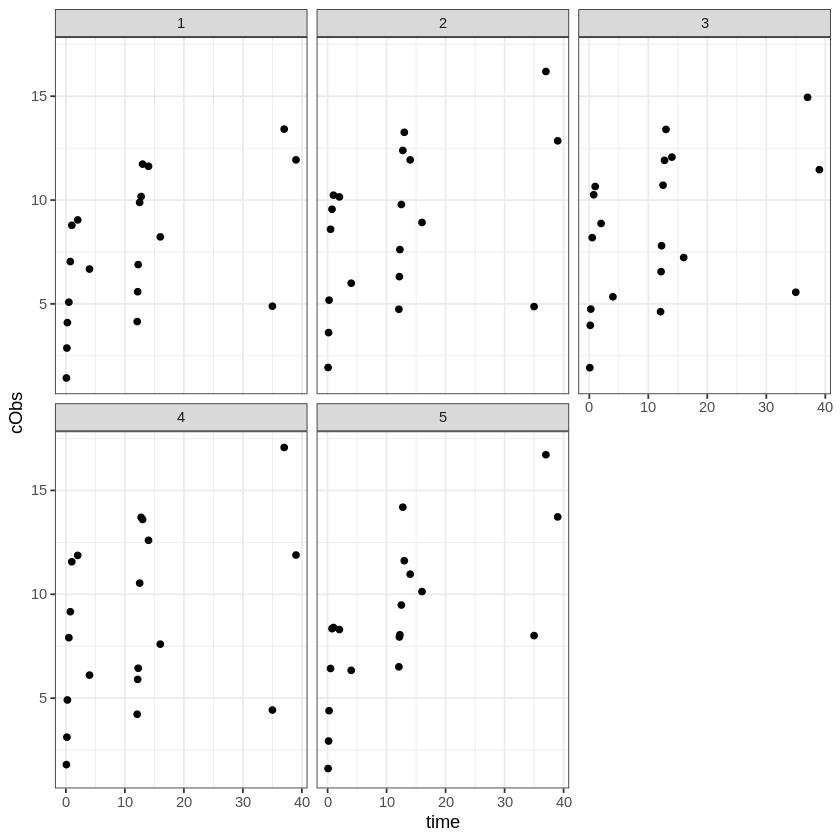

In [9]:
# plot data
patientID <- rep(NA, data$nSubjects)
for (i in 1:data$nSubjects) {
  patientID[data$start[i]:data$end[i]] <- i
}

p <- ggplot(data = data.frame(cObs = data$cObs, time = data$time[data$iObs],
                              ID = patientID[data$iObs]), aes(x = time, y = cObs)) +
  theme_bw() + geom_point() + facet_wrap(~ID)
p

In [10]:
# Draw initial points from the prior
init <- function () {
  n_subjects <- data$nSubjects
  pop_var <- c(0.2, 0.2, 0.2, 0.2, 0.2)

  CL_pop <- exp(rnorm(1, log(10), pop_var[1]))
  Q_pop <- exp(rnorm(1, log(15), pop_var[2]))
  VC_pop <- exp(rnorm(1, log(35), pop_var[3]))
  VP_pop <- exp(rnorm(1, log(105), pop_var[4]))
  ka_pop <- exp(rnorm(1, log(2.5), pop_var[5]))
  omega <- abs(rnorm(5, 0, pop_var))

  theta_pop <- c(CL_pop, Q_pop, VC_pop, VP_pop, ka_pop)
  theta <- matrix(NA, n_subjects, length(theta_pop))
  for (j in 1:n_subjects) {
    theta[j, ] <- exp(rnorm(length(theta_pop), log(theta_pop), omega))
  }

  list(CL_pop = CL_pop, Q_pop = Q_pop, VC_pop = VC_pop, VP_pop = VP_pop,
       ka_pop = ka_pop, omega = omega, theta = theta,
       sigma = abs(rnorm(1, 0, 1)))
}


In [11]:
model_name <- "twoCptPop"
mod <- cmdstan_model(paste0("model/", model_name, ".stan"))


ERROR: ignored

In [50]:
n_chains <- 4
fit <- mod$sample(data = data, chains = n_chains, init = init,
                  parallel_chains = detectCores(),
                  iter_warmup = 500, iter_sampling = 500,
                  seed = 1234, adapt_delta = 0.8)

Init values were only set for a subset of parameters. 
Missing init values for the following parameters:
 - chain 1: eta
 - chain 2: eta
 - chain 3: eta
 - chain 4: eta




Running MCMC with 4 chains, at most 2 in parallel...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: PMXTwoCptModel: CL is 0, but must be positive finite! (in '/tmp/RtmpBMyYdw/model-18431a55471.stan', line 54, column 4 to line 62, column 59)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: PMXTwoCptModel: CL is 0, but must be positive finite! (in '/tmp/RtmpBMyYdw/model-18431a55471.stan', line 54, column 4 to line 62, column 59)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warnin

Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: PMXTwoCptModel: Q is inf, but must be positive finite! (in '/tmp/RtmpBMyYdw/model-18431a55471.stan', line 54, column 4 to line 62, column 59)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: PMXTwoCptModel: V2 is inf, but must be positive finite! (in '/tmp/RtmpBMyYdw/model-18431a55471.stan', line 54, column 4 to line 62, column 59)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 172.9 seconds.
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: PMXTwoCptModel: CL is inf, but must be positive finite! (in '/tmp/RtmpBMyYdw/model-18431a55471.stan', line 54, column 4 to line 62, column 59)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 



Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 finished in 186.0 seconds.
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: PMXTwoCptModel: Q is inf, but must be positive finite! (in '/tmp/RtmpBMyYdw/model-18431a55471.stan', line 54, column 4 to line 62, column 59)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 



Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 3 finished in

See https://mc-stan.org/misc/warnings for details.




In [51]:
fit$save_object(paste0("deliv/", model_name, ".fit.RDS"))

In [52]:
fit$time()

chain_id,warmup,sampling,total
<int>,<dbl>,<dbl>,<dbl>
1,107.429,65.490,172.919
2,110.732,75.290,186.022
3,118.253,72.539,190.792
4,122.652,69.390,192.042


variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,89.17737100,89.5202500,5.296247722,5.274868410,79.94258500,97.13346500,1.010736,399.7965,1008.6796
CL_pop,9.96235801,9.9226450,0.840885850,0.776519163,8.63371600,11.36522500,1.000303,1126.5700,1307.6748
Q_pop,26.84601900,26.6016000,4.028605269,3.835708590,20.57262500,33.78559500,1.003354,970.3524,892.6707
VC_pop,42.45768420,41.8180000,6.463769282,6.213650730,32.82727500,53.81761500,1.002159,1432.7098,1011.8662
VP_pop,116.15089755,114.7050000,14.321436561,13.893444600,95.17092500,141.10755000,1.002864,1463.9898,1286.2362
ka_pop,0.82505388,0.8171040,0.126092454,0.124190730,0.64081130,1.03756850,1.000972,1413.4441,907.4859
sigma,0.06630171,0.0659512,0.005553412,0.005479467,0.05814001,0.07595155,1.001230,1568.6546,1339.8582


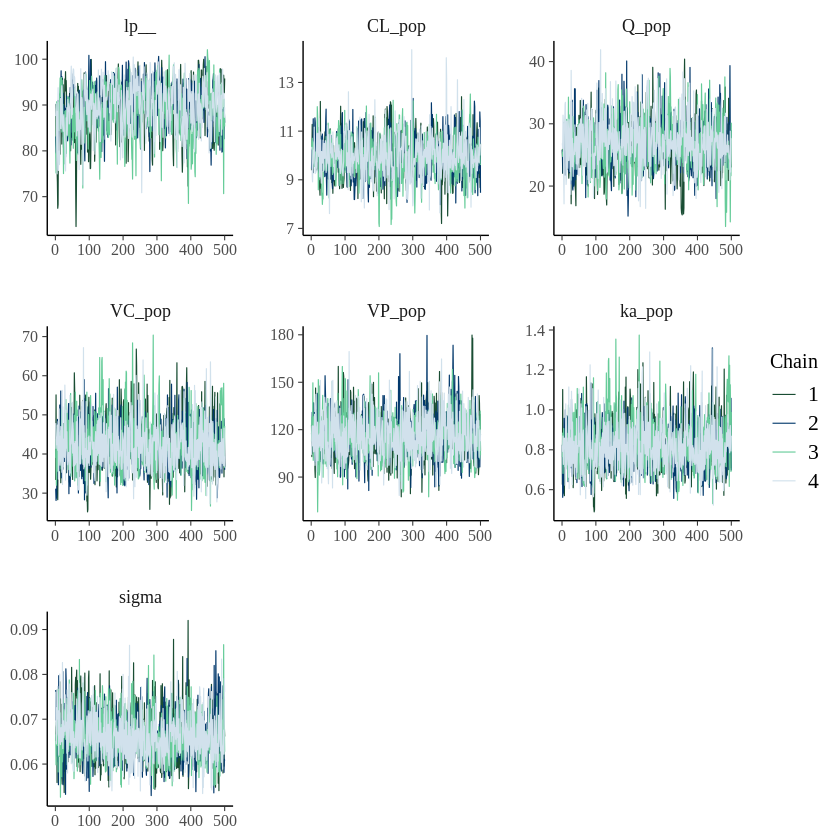

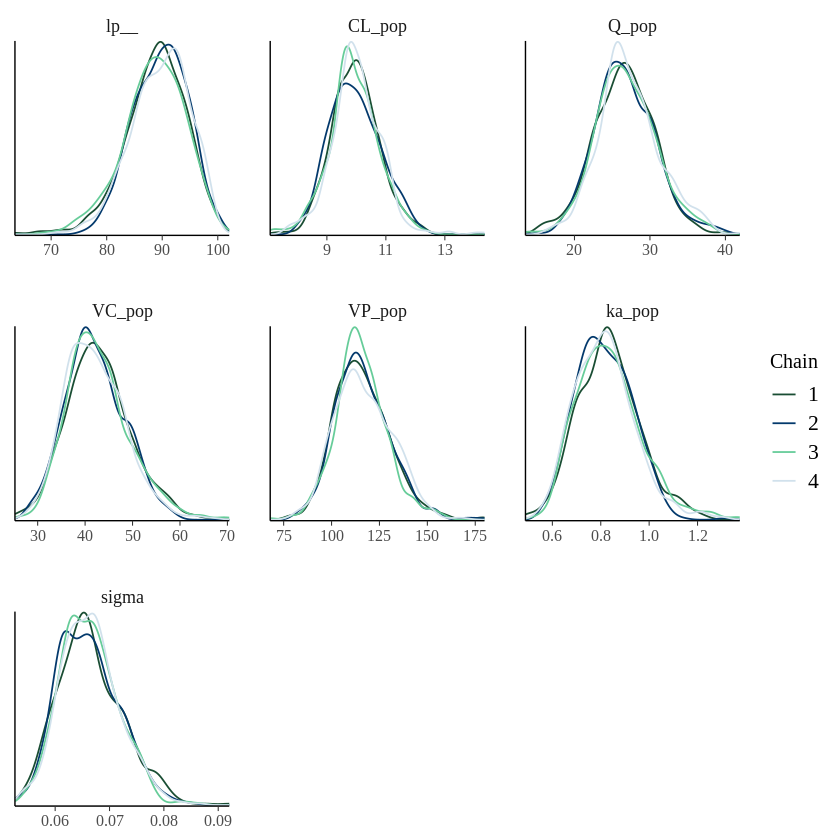

In [53]:
pars = c("lp__", "CL_pop", "Q_pop", "VC_pop", "VP_pop", "ka_pop", "sigma")
fit$summary(variables = pars)
bayesplot::mcmc_trace(fit$draws(), pars = pars)
bayesplot::mcmc_dens_overlay(fit$draws(), pars = pars)

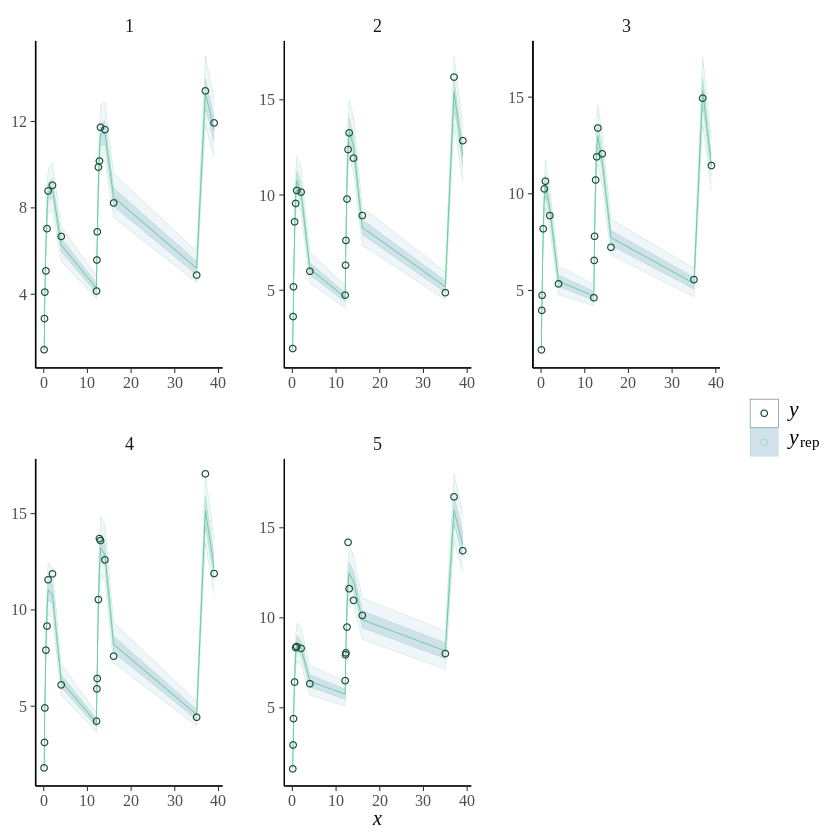

In [54]:
# posterior predictive checks
yrep <- as.matrix(
  as_draws_df(
    fit$draws(variables = c("concentrationObsPred"))))
yrep <- yrep[, -((ncol(yrep) - 2):ncol(yrep))]

yobs <- data$cObs
time <- data$time[data$iObs]
patientID <- with(data, rep(1:nSubjects, each = nObs / nSubjects))

# within patient predictions
bayesplot::ppc_ribbon_grouped(y = yobs, yrep = yrep, x = time, patientID,
                              y_draw = "point")

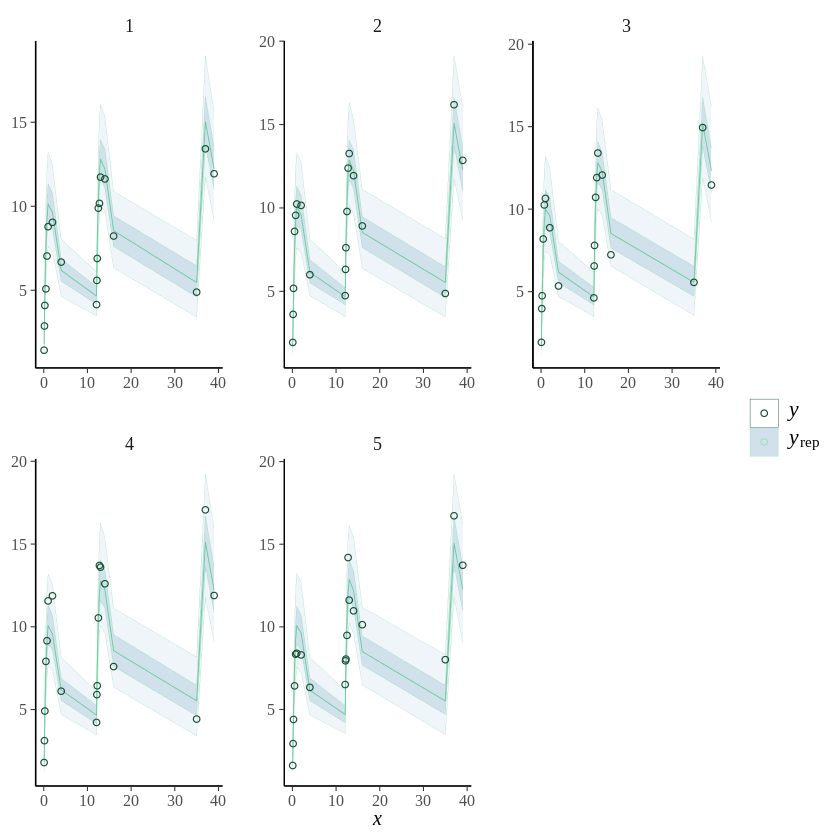

In [55]:
# predictions for new patient
yrepNew <- as.matrix(
  as_draws_df(
    fit$draws(variables = c("cObsNewPred"))))
yrepNew <- yrepNew[, -((ncol(yrepNew) - 2):ncol(yrepNew))]

bayesplot::ppc_ribbon_grouped(y = yobs, yrep = yrepNew, x = time, patientID,
                              y_draw = "point")

In [12]:
# Implementation with multiple threads per chain
model_name <- "twoCptPop_rs"
mod <- cmdstan_model(paste0("model/", model_name, ".stan"),
                     cpp_options = list(stan_threads = TRUE))


In file included from stan/lib/stan_math/lib/boost_1.75.0/boost/concept/assert.hpp:35,
                 from stan/lib/stan_math/lib/boost_1.75.0/boost/concept_check.hpp:20,
                 from stan/lib/stan_math/lib/boost_1.75.0/boost/range/concepts.hpp:19,
                 from stan/lib/stan_math/lib/boost_1.75.0/boost/range/size_type.hpp:20,
                 from stan/lib/stan_math/lib/boost_1.75.0/boost/range/size.hpp:21,
                 from stan/lib/stan_math/lib/boost_1.75.0/boost/range/functions.hpp:20,
                 from stan/lib/stan_math/lib/boost_1.75.0/boost/range/iterator_range_core.hpp:38,
                 from stan/lib/stan_math/lib/boost_1.75.0/boost/lexical_cast.hpp:30,
                 from stan/src/stan/callbacks/writer.hpp:4,
                 from src/cmdstan/arguments/argument.hpp:4,
                 from src/cmdstan/arguments/categorical_argument.hpp:4,
                 from src/cmdstan/arguments/arg_data.hpp:4,
                 from src/cmdstan/command.hpp:

In [16]:
n_chains <- 1
fit_rs <- mod$sample(data = data, chains = n_chains, init = init,
                     parallel_chains = n_chains,
                     threads_per_chain = 1,
                     iter_warmup = 500, iter_sampling = 500,
                     seed = 123, adapt_delta = 0.8)

Init values were only set for a subset of parameters. 
Missing init values for the following parameters:
eta




Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: Exception: lognormal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/RtmpfsOUHi/model-1086535c47d.stan', line 65, column 4 to column 69) (in '/tmp/RtmpfsOUHi/model-1086535c47d.stan', line 136, column 2 to line 139, column 65)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: Exception: PMXTwoCptModel: CL is -nan, but must be positive finite! (in '/tmp/RtmpfsOUHi/model-1086535c47d.stan', line 41, column 6 to line 50, column 39) (in '/tmp/RtmpfsOUHi/model-1086535c47d.stan', line 13

Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 98.1 seconds.


In [17]:
fit_rs$time()
# fit_rs$summary(variables = pars)

chain_id,warmup,sampling,total
<int>,<dbl>,<dbl>,<dbl>
1,58.086,40.031,98.117
